# Image Captioning - Data Exploration

This notebook explores the Flickr8k dataset for the image captioning task. We will:

1. Download and prepare the dataset
2. Explore the images and captions
3. Analyze the distribution of caption lengths
4. Examine the vocabulary
5. Visualize some sample images with their captions

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import nltk
from collections import Counter
from tqdm import tqdm
import re
import string
import seaborn as sns

# Add project root to path
sys.path.append('/content/drive/MyDrive/image_captioning/image-captioning')

# Import project modules
from data.download_flickr import download_flickr8k
from utils.vocabulary import Vocabulary, build_vocab_from_captions

## 1. Download and Prepare the Dataset

In [ ]:
# Download and prepare the Flickr8k dataset
data_dir = '/content/drive/MyDrive/image_captioning/image-captioning/data'
paths = download_flickr8k(data_dir)

File already exists at /content/drive/MyDrive/image_captioning/image-captioning/data/flickr8k/Flickr8k_Dataset.zip. Skipping download.
File already exists at /content/drive/MyDrive/image_captioning/image-captioning/data/flickr8k/Flickr8k_text.zip. Skipping download.


Extracting Flickr8k_text.zip: 100%|██████████| 10/10 [00:04<00:00,  2.27it/s]


Processed captions saved to /content/drive/MyDrive/image_captioning/image-captioning/data/flickr8k/processed/captions.csv


Organizing images: 100%|██████████| 8091/8091 [00:29<00:00, 273.91it/s] 


Images organized in /content/drive/MyDrive/image_captioning/image-captioning/data/flickr8k/processed/images
Created data splits: train (30000 captions), val (5000 captions), test (5000 captions)


In [ ]:
# Load the captions
captions_path = os.path.join(paths['processed_path'], 'captions.csv')
captions_df = pd.read_csv(captions_path)

# Display the first few rows
captions_df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,<start> a child in a pink dress is climbing up...
1,1000268201_693b08cb0e.jpg,<start> a girl going into a wooden building <end>
2,1000268201_693b08cb0e.jpg,<start> a little girl climbing into a wooden p...
3,1000268201_693b08cb0e.jpg,<start> a little girl climbing the stairs to h...
4,1000268201_693b08cb0e.jpg,<start> a little girl in a pink dress going in...


## 2. Explore the Images and Captions

In [ ]:
# Count unique images and total captions
unique_images = captions_df['image'].nunique()
total_captions = len(captions_df)

print(f"Total number of images: {unique_images}")
print(f"Total number of captions: {total_captions}")
print(f"Average captions per image: {total_captions / unique_images:.2f}")

Total number of images: 8092
Total number of captions: 40460
Average captions per image: 5.00


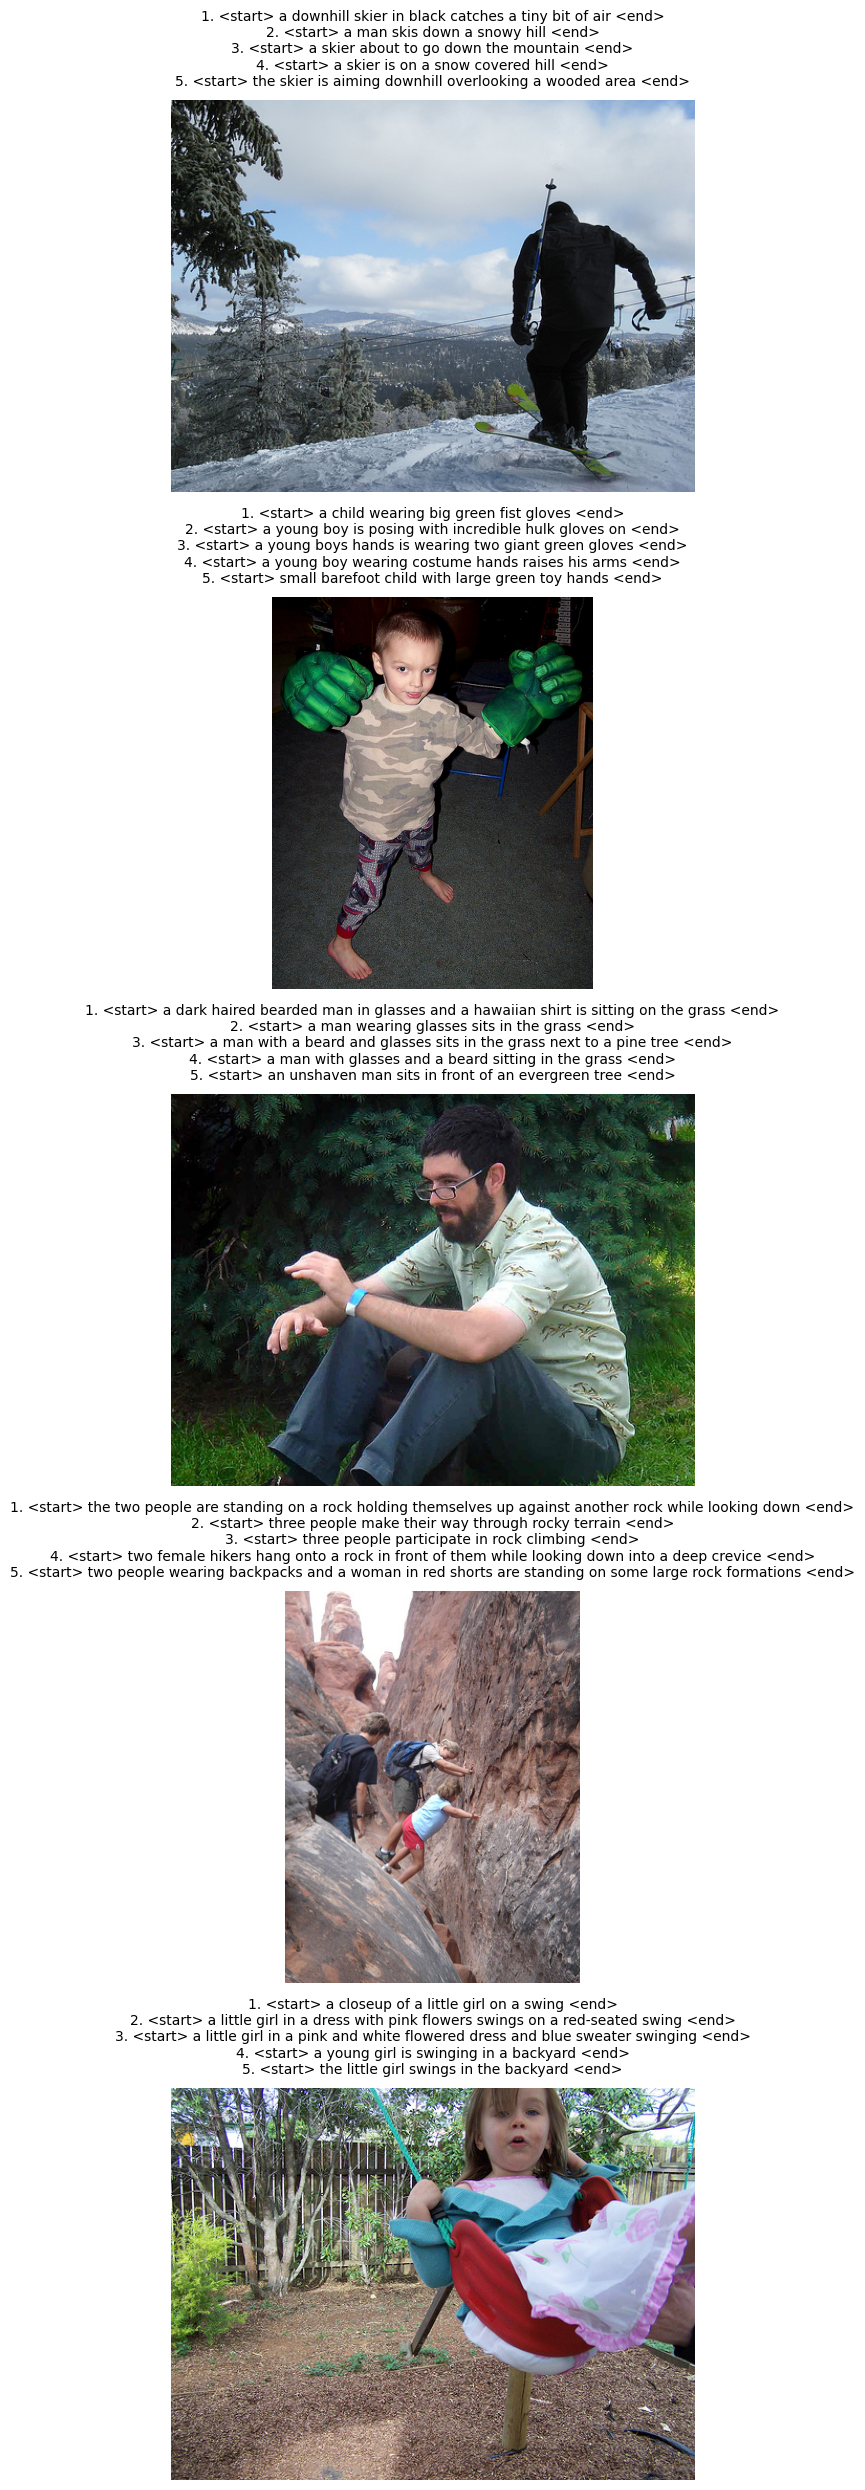

In [ ]:
# Display a random sample of images with their captions
# TODO: Implement the function to display images with their captions
# This function should:
# 1. Take a DataFrame of captions, path to images directory, and number of samples
# 2. Get random image samples
# 3. Create a figure with subplots
# 4. For each image:
#    a. Load and display the image
#    b. Find all captions for that image
#    c. Add captions as a formatted title
    # Your implementation here
def display_images_with_captions(captions_df, images_dir, num_samples=5):
    # Get unique images
    unique_image_df = captions_df.drop_duplicates(subset=['image'])

    # Select random sample of images
    sampled_images = unique_image_df['image'].sample(n=num_samples, random_state=42).tolist()

    # Set up the figure with subplots
    fig, axes = plt.subplots(num_samples, 1, figsize=(10, 5 * num_samples))

    # Ensure axes is a list even for a single sample
    if num_samples == 1:
        axes = [axes]

    # Iterate through sampled images
    for i, image_name in enumerate(sampled_images):
        # Load the image
        image_path = os.path.join(images_dir, image_name)
        image = Image.open(image_path)

        # Get all captions for the image
        captions = captions_df[captions_df['image'] == image_name]['caption'].tolist()

        # Format captions as a single string for the title
        caption_text = '\n'.join([f"{idx+1}. {caption}" for idx, caption in enumerate(captions)])

        # Display the image
        axes[i].imshow(image)
        axes[i].set_title(caption_text, fontsize=10, pad=10)
        axes[i].axis('off')  # Hide axes for cleaner display

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

# Display some sample images with their captions
images_dir = os.path.join(paths['processed_path'], 'images')
display_images_with_captions(captions_df, images_dir)

## 3. Analyze Caption Lengths

In [ ]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
import re
import nltk
from nltk.tokenize import word_tokenize

# Download NLTK tokenizer data (only needs to be done once)
nltk.download('punkt', quiet=True)

def tokenize(text):
    """
    Tokenizes input caption text into a list of words for image captioning preprocessing.

    Args:
        text (str): Input caption text to be tokenized.

    Returns:
        list: List of word tokens after converting to lowercase and removing punctuation.

    Steps:
        1. Convert text to lowercase to ensure consistency.
        2. Remove punctuation using regex to keep only words and spaces.
        3. Split text into tokens using NLTK's word_tokenize for accurate word splitting.
        4. Filter out empty tokens for cleaner output.
    """
    try:
        # Step 1: Convert text to lowercase
        text = text.lower()

        # Step 2: Remove punctuation using regex
        text = re.sub(r'[^\w\s]', ' ', text)

        # Step 3: Split text into tokens using NLTK's word_tokenize
        tokens = word_tokenize(text)

        # Step 4: Remove empty tokens and extra whitespace
        tokens = [token.strip() for token in tokens if token.strip()]

        return tokens
    except Exception as e:
        print(f"Error tokenizing text '{text}': {e}")
        return []

# Calculate caption lengths
captions_df['tokens'] = captions_df['caption'].apply(tokenize)
captions_df['length'] = captions_df['tokens'].apply(len)

# Display statistics
caption_lengths = captions_df['length']
print(f"Min length: {caption_lengths.min()}")
print(f"Max length: {caption_lengths.max()}")
print(f"Mean length: {caption_lengths.mean():.2f}")
print(f"Median length: {caption_lengths.median()}")
print(f"90th percentile length: {caption_lengths.quantile(0.9)}")
print(f"95th percentile length: {caption_lengths.quantile(0.95)}")


Min length: 3
Max length: 39
Mean length: 12.82
Median length: 12.0
90th percentile length: 18.0
95th percentile length: 20.0


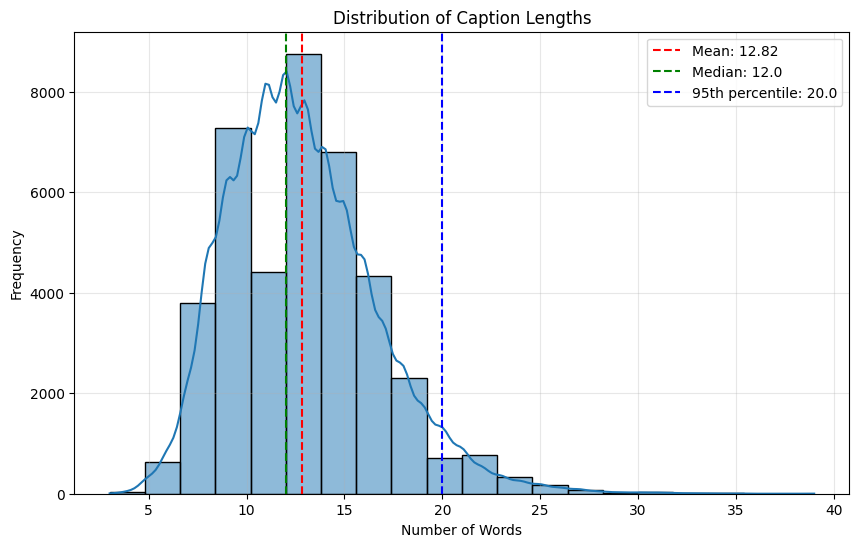

In [ ]:
# Plot the distribution of caption lengths
plt.figure(figsize=(10, 6))
sns.histplot(caption_lengths, bins=20, kde=True)
plt.axvline(x=caption_lengths.mean(), color='r', linestyle='--', label=f'Mean: {caption_lengths.mean():.2f}')
plt.axvline(x=caption_lengths.median(), color='g', linestyle='--', label=f'Median: {caption_lengths.median()}')
plt.axvline(x=caption_lengths.quantile(0.95), color='b', linestyle='--', label=f'95th percentile: {caption_lengths.quantile(0.95)}')
plt.title('Distribution of Caption Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 4. Examine the Vocabulary

In [ ]:
# Count word frequencies
all_tokens = [token for tokens in captions_df['tokens'] for token in tokens]
word_freq = Counter(all_tokens)

# Display statistics
print(f"Total vocabulary size: {len(word_freq)}")
print(f"Number of words appearing only once: {sum(1 for count in word_freq.values() if count == 1)}")

Total vocabulary size: 8484
Number of words appearing only once: 3334


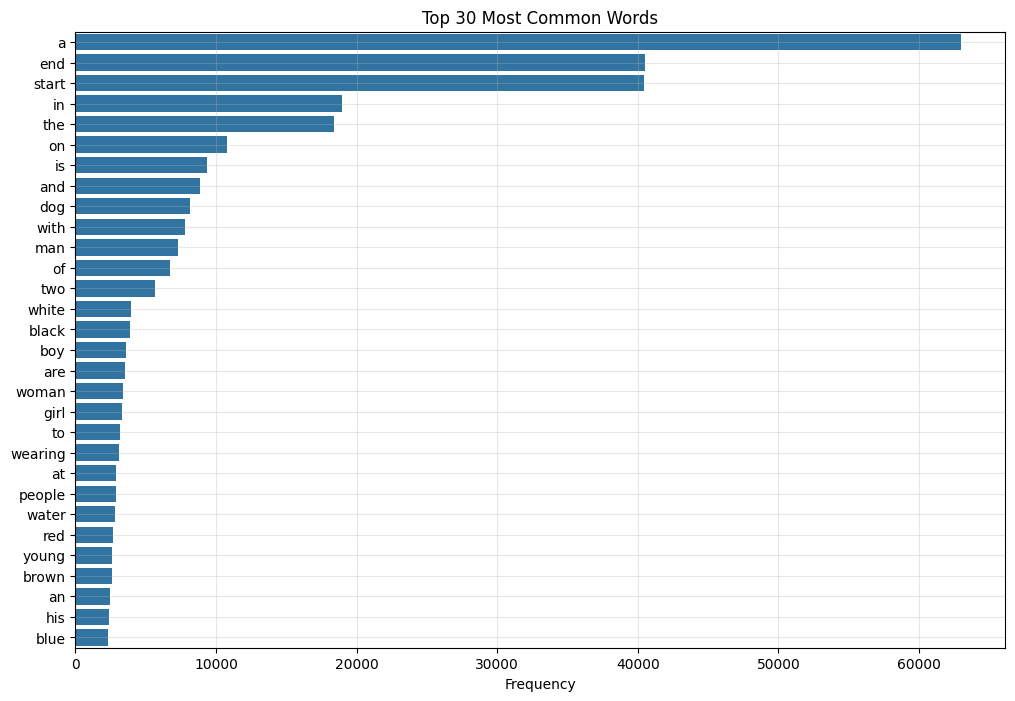

In [ ]:
# Plot the most common words
top_n = 30
most_common = word_freq.most_common(top_n)
words, counts = zip(*most_common)

plt.figure(figsize=(12, 8))
sns.barplot(x=list(counts), y=list(words))
plt.title(f'Top {top_n} Most Common Words')
plt.xlabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Calculate vocabulary coverage with different frequency thresholds
# TODO: Calculate vocabulary coverage for different word frequency thresholds
# For each threshold:
# 1. Find words that appear at least 'threshold' times
# 2. Calculate vocabulary size (number of unique words above threshold)
# 3. Calculate what percentage of all tokens are covered by this vocabulary
# 4. Store results for plotting
from collections import Counter

# Assuming all_tokens is already computed as a list of all tokens from captions_df['tokens']
# Calculate vocabulary coverage with different frequency thresholds
thresholds = [1, 2, 3, 5, 10]
coverage = []

# Total number of tokens
total_tokens = len(all_tokens)

for threshold in thresholds:
    # Step 1: Find words that appear at least 'threshold' times
    word_counts = Counter(all_tokens)
    vocab = [word for word, count in word_counts.items() if count >= threshold]

    # Step 2: Calculate vocabulary size (number of unique words above threshold)
    vocab_size = len(vocab)

    # Step 3: Calculate what percentage of all tokens are covered by this vocabulary
    covered_tokens = sum(count for word, count in word_counts.items() if count >= threshold)
    coverage_pct = (covered_tokens / total_tokens) * 100 if total_tokens > 0 else 0

    # Step 4: Store results for plotting
    coverage.append((threshold, vocab_size, coverage_pct))

    print(f"Threshold: {threshold}, Vocabulary size: {vocab_size}, Coverage: {coverage_pct:.2f}%")

Threshold: 1, Vocabulary size: 8484, Coverage: 100.00%
Threshold: 2, Vocabulary size: 5150, Coverage: 99.36%
Threshold: 3, Vocabulary size: 4077, Coverage: 98.94%
Threshold: 5, Vocabulary size: 2977, Coverage: 98.22%
Threshold: 10, Vocabulary size: 1967, Coverage: 96.94%


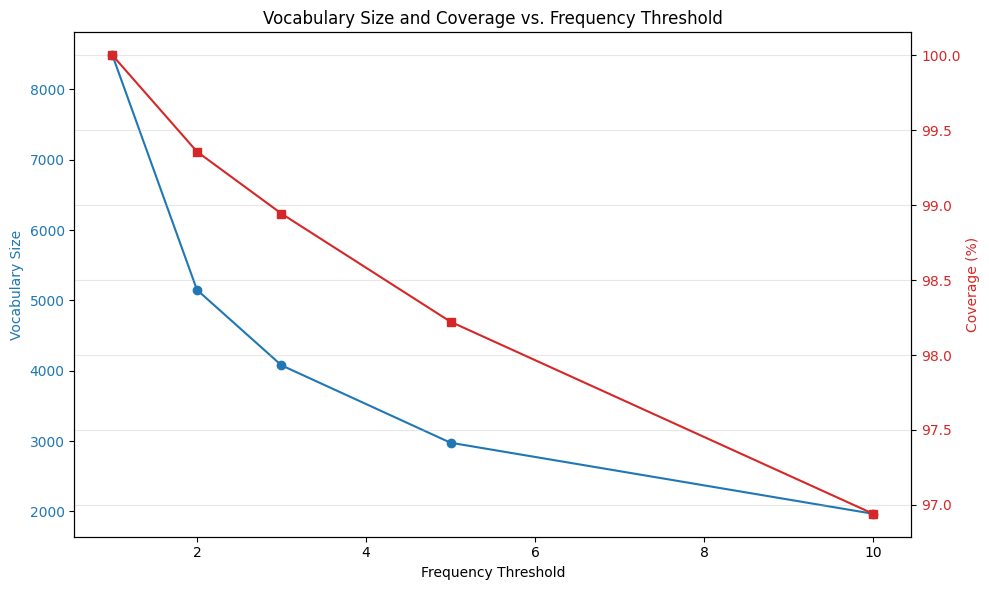

In [ ]:
# Plot vocabulary coverage
thresholds, vocab_sizes, coverages = zip(*coverage)

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot vocabulary size
color = 'tab:blue'
ax1.set_xlabel('Frequency Threshold')
ax1.set_ylabel('Vocabulary Size', color=color)
ax1.plot(thresholds, vocab_sizes, 'o-', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create second y-axis for coverage
ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Coverage (%)', color=color)
ax2.plot(thresholds, coverages, 's-', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Vocabulary Size and Coverage vs. Frequency Threshold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Build and Save the Vocabulary

In [ ]:
# Build and save the vocabulary
freq_threshold = 5  # Words appearing less than 5 times are considered rare
vocab = build_vocab_from_captions(captions_path, paths['processed_path'], freq_threshold=freq_threshold)

print(f"Built vocabulary with {len(vocab)} words")

Building vocabulary: 100%|██████████| 40460/40460 [00:02<00:00, 13635.49it/s]


Vocabulary built with 2986 words
Saved to /content/drive/MyDrive/image_captioning/image-captioning/data/flickr8k/processed/vocabulary.pkl
Built vocabulary with 2986 words


## 6. Explore Data Splits

In [ ]:
# Load data splits
train_df = pd.read_csv(os.path.join(paths['processed_path'], 'train.csv'))
val_df = pd.read_csv(os.path.join(paths['processed_path'], 'val.csv'))
test_df = pd.read_csv(os.path.join(paths['processed_path'], 'test.csv'))

# Display statistics
print(f"Training set: {train_df['image'].nunique()} images, {len(train_df)} captions")
print(f"Validation set: {val_df['image'].nunique()} images, {len(val_df)} captions")
print(f"Test set: {test_df['image'].nunique()} images, {len(test_df)} captions")

Training set: 6000 images, 30000 captions
Validation set: 1000 images, 5000 captions
Test set: 1000 images, 5000 captions


## 7. Check Image Dimensions

In [ ]:
# Check image dimensions for a sample of images
# TODO: Implement a function to analyze image dimensions in the dataset
# This function should:
# 1. Get a sample of image files from the directory
# 2. Load each image and extract its dimensions
# 3. Return a DataFrame with width and height columns for analysis



Found 8101 image files in '/content/drive/MyDrive/image_captioning/image-captioning/data/flickr8k/processed/images'
Error processing images in directory '/content/drive/MyDrive/image_captioning/image-captioning/data/flickr8k/processed/images': name 'random' is not defined
Image dimension statistics:
       image width height aspect_ratio
count      0     0      0            0
unique     0     0      0            0
top      NaN   NaN    NaN          NaN
freq     NaN   NaN    NaN          NaN


In [ ]:
import os
import pandas as pd
from PIL import Image
import random

def check_image_dimensions(images_dir, num_samples=100):
    """
    Analyzes dimensions of a sample of images from the dataset.

    Args:
        images_dir (str): Path to the directory containing images.
        num_samples (int): Number of images to sample (default: 100).

    Returns:
        pandas.DataFrame: DataFrame with columns 'image', 'width', 'height', and 'aspect_ratio'.
    """
    try:
        # Step 1: Verify that the directory exists
        if not os.path.isdir(images_dir):
            print(f"Directory '{images_dir}' does not exist.")
            return pd.DataFrame(columns=['image', 'width', 'height', 'aspect_ratio'])

        # Step 2: Get a list of image files from the directory
        image_files = [f for f in os.listdir(images_dir) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

        # Debug: Check if any image files were found
        print(f"Found {len(image_files)} image files in '{images_dir}'")

        if not image_files:
            print("No image files found in the directory.")
            return pd.DataFrame(columns=['image', 'width', 'height', 'aspect_ratio'])

        # Step 3: Randomly sample the specified number of images
        sampled_images = random.sample(image_files, min(num_samples, len(image_files)))

        # Debug: Confirm sampled images
        print(f"Sampled {len(sampled_images)} images for analysis.")

        # Step 4: Load each image and extract its dimensions
        dimensions = []
        for image_name in sampled_images:
            image_path = os.path.join(images_dir, image_name)
            try:
                with Image.open(image_path) as img:
                    width, height = img.size
                    aspect_ratio = width / height if height > 0 else 0  # Avoid division by zero
                    dimensions.append({'image': image_name, 'width': width, 'height': height, 'aspect_ratio': aspect_ratio})
            except Exception as e:
                print(f"Error loading image '{image_name}': {e}")
                continue

        # Debug: Check how many images were successfully processed
        print(f"Successfully processed {len(dimensions)} images.")

        # Step 5: Return a DataFrame with width, height, and aspect_ratio columns
        if not dimensions:
            print("No images were successfully processed.")
            return pd.DataFrame(columns=['image', 'width', 'height', 'aspect_ratio'])

        dim_df = pd.DataFrame(dimensions)
        return dim_df

    except Exception as e:
        print(f"Error processing images in directory '{images_dir}': {e}")
        return pd.DataFrame(columns=['image', 'width', 'height', 'aspect_ratio'])

# Check dimensions
image_dimensions = check_image_dimensions(images_dir)

# Display statistics
print("Image dimension statistics:")
print(image_dimensions.describe())


Found 8101 image files in '/content/drive/MyDrive/image_captioning/image-captioning/data/flickr8k/processed/images'
Sampled 100 images for analysis.
Successfully processed 100 images.
Image dimension statistics:
            width      height  aspect_ratio
count  100.000000  100.000000    100.000000
mean   448.850000  403.090000      1.185640
std     74.134791   78.802412      0.379094
min    256.000000  233.000000      0.512000
25%    375.000000  333.000000      0.750000
50%    500.000000  375.000000      1.333333
75%    500.000000  500.000000      1.501502
max    500.000000  500.000000      2.145923


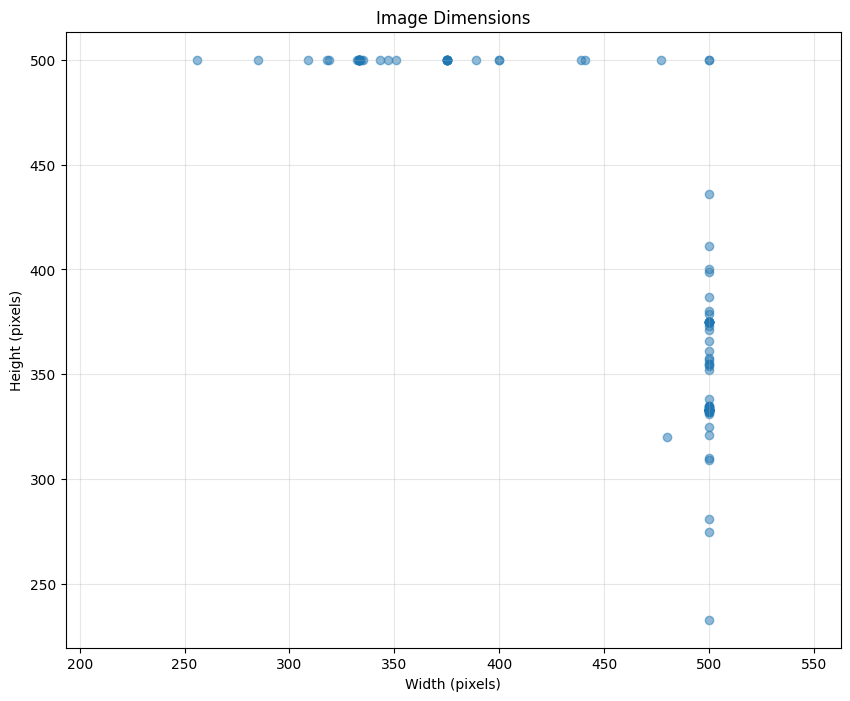

In [ ]:
# Plot image dimensions
plt.figure(figsize=(10, 8))
plt.scatter(image_dimensions['width'], image_dimensions['height'], alpha=0.5)
plt.title('Image Dimensions')
plt.xlabel('Width (pixels)')
plt.ylabel('Height (pixels)')
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.show()

## Summary

In this notebook, we have explored the Flickr8k dataset for image captioning. We have:

1. Downloaded and prepared the dataset
2. Explored the images and captions
3. Analyzed the distribution of caption lengths
4. Examined the vocabulary and its coverage
5. Built and saved the vocabulary
6. Explored the data splits
7. Checked image dimensions

This exploration gives us a good understanding of the dataset and helps us make informed decisions when designing our image captioning model.